In [181]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)
from collections import defaultdict

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

In [182]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")

model1 = sbm.SeismicCNN.from_pretrained("base", version_str = '1')
model2 = sbm.SeismicCNN.from_pretrained("base", version_str = '2')
model3 = sbm.SeismicCNN.from_pretrained("base", version_str = '3')
model4 = sbm.SeismicCNN.from_pretrained("base", version_str = '4')
model5 = sbm.SeismicCNN.from_pretrained("base", version_str = '5')
model6 = sbm.SeismicCNN.from_pretrained("base", version_str = '6')

In [183]:
retest_cat = pd.read_csv('../../data/curated_new_explosions_data_for_retesting.csv', index_col = 0)
event_ids = retest_cat['event_id'].values
stn_list = retest_cat['station'].values


In [184]:
retest_cat

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label
3634,613,AGNW,0.007429,0.145115,0.625048,0.999631,0.999631,surface,65.960369,surface
3636,613,H2O,0.025686,0.707756,0.825063,0.999868,0.999868,surface,60.741691,surface
3637,613,PRO,0.029811,0.374436,0.992602,0.999868,0.999868,surface,52.151577,surface
3638,613,SNI2,0.042300,0.956481,0.611664,0.999122,0.999122,surface,51.560611,surface
3639,613,YPT,0.005421,0.855344,0.999999,0.998845,0.998845,surface,76.740406,surface
...,...,...,...,...,...,...,...,...,...,...
8382,1442,VDEB,0.029686,0.929208,0.995216,0.999971,0.999971,surface,56.570425,surface
8383,1444,COWS,0.554897,0.483584,0.997621,0.238631,0.554897,eq,7.470058,surface
8384,1444,FMW,0.247488,0.779325,0.774267,0.999721,0.999721,surface,48.308821,surface
8385,1444,RER,0.132664,0.845789,0.999380,0.946960,0.946960,surface,24.590500,surface


In [185]:
df = pd.read_csv('../../src/pnw_explosion_2023_2025.csv')

In [188]:
retest_cat

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label
3634,613,AGNW,0.007429,0.145115,0.625048,0.999631,0.999631,surface,65.960369,surface
3636,613,H2O,0.025686,0.707756,0.825063,0.999868,0.999868,surface,60.741691,surface
3637,613,PRO,0.029811,0.374436,0.992602,0.999868,0.999868,surface,52.151577,surface
3638,613,SNI2,0.042300,0.956481,0.611664,0.999122,0.999122,surface,51.560611,surface
3639,613,YPT,0.005421,0.855344,0.999999,0.998845,0.998845,surface,76.740406,surface
...,...,...,...,...,...,...,...,...,...,...
8382,1442,VDEB,0.029686,0.929208,0.995216,0.999971,0.999971,surface,56.570425,surface
8383,1444,COWS,0.554897,0.483584,0.997621,0.238631,0.554897,eq,7.470058,surface
8384,1444,FMW,0.247488,0.779325,0.774267,0.999721,0.999721,surface,48.308821,surface
8385,1444,RER,0.132664,0.845789,0.999380,0.946960,0.946960,surface,24.590500,surface


In [199]:
ev_id

613

In [192]:

stn

'AGNW'

In [200]:
ev_id = retest_cat['event_id'].values[0]
stn = retest_cat['station'].values[0]
files = glob(f"../../data/pnw_new_explosion_2023_2025/waveforms/{ev_id}/*{stn}*")

st = []
for file in files:
    st += obspy.read(file)
    
st = obspy.Stream(st)
st.detrend('linear')
st.taper(0.1)
st.filter('bandpass', freqmin = 1, freqmax = 20)

probs_px = model3.annotate(st, stride = 100)[1].data
probs_su = model3.annotate(st, stride = 100)[3].data
times_px = model3.annotate(st, stride = 100)[1].times()

probs = np.array(model3.annotate(st, stride = 100))  #.plot()



plt.figure(figsize = [10,3])

plt.plot(st[2].times(), st[2].data/np.max(abs(st[2].data)), alpha = 0.5)
plt.plot(times_px, probs_px)
plt.plot(times_px, probs_su)

2025-07-06 13:47:06,497 | seisbench | WARNING | Unknown argument 'output_probabilities' will be ignored.
2025-07-06 13:47:06,649 | seisbench | WARNING | Unknown argument 'step' will be ignored.
2025-07-06 13:47:06,650 | seisbench | WARNING | Unknown argument 'output_probabilities' will be ignored.


ValueError: x and y must have same first dimension, but have shapes (4,) and (86,)

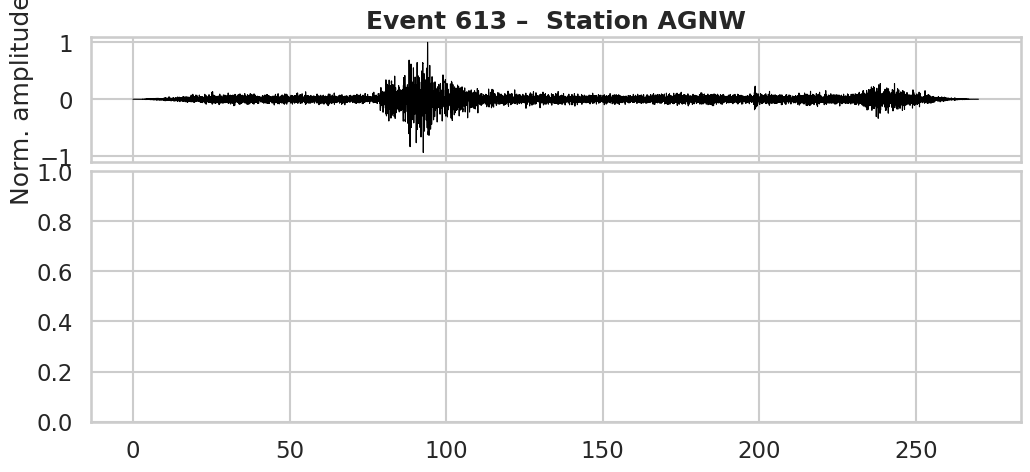

In [243]:
sns.set_context("talk")              # larger fonts
sns.set_style("whitegrid")           # light grid behind probs

# ------------------------------------------------------------------
# 1. Load & preprocess waveform
# ------------------------------------------------------------------

ev_id = retest_cat['event_id'].values[0]
stn = retest_cat['station'].values[0]

files = glob(f"../../data/pnw_new_explosion_2023_2025/waveforms/{ev_id}/*{stn}*")

st = obspy.Stream(sum((obspy.read(f) for f in files), obspy.Stream()))
st.detrend("linear").taper(0.1).filter("bandpass", freqmin = 1, freqmax = 20)

# ------------------------------------------------------------------
# 2. Annotate once (stride = 100 s)
# ------------------------------------------------------------------
probs   = np.asarray(model3.annotate(st, stride =100, output_probabilities=True))
times   = model3.annotate(st, step=100, output_probabilities=True)[1].times()

prob_px = probs[1]      # explosion
prob_su = probs[3]      # surface

# ------------------------------------------------------------------
# 3. Plot
# ------------------------------------------------------------------
fig, (ax0, ax1) = plt.subplots(
    2, 1, figsize=(12, 5), sharex=True,
    gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05}
)

# --- Top: normalized vertical component (HHZ/BHZ) -----------------
z = st.select(component="Z")[0]
ax0.plot(z.times(), z.data / np.abs(z.data).max(), color="k", lw=0.8)
ax0.set_ylabel("Norm. amplitude")
ax0.set_title(f"Event {ev_id} –  Station {stn}", weight="bold")
ax0.set_ylim(-1.1, 1.1)
ax0.tick_params(axis="x", which="both", length=0)   # hide x-ticks

# --- Bottom: class probabilities ----------------------------------
ax1.plot(times, prob_px, label="Explosion $P_{px}$", color=sns.color_palette("Set2")[1], lw=2)
ax1.plot(times, prob_su, label="Surface $P_{su}$",  color=sns.color_palette("Set2")[0], lw=2)
ax1.set_xlabel("Time since trace start (s)")
ax1.set_ylabel("Probability")
ax1.set_ylim(0, 1.02)
ax1.legend(frameon=False, loc="upper right")
ax1.axhline(0.5, color="gray", ls="--", lw=0.8)      # 0.5 threshold guide

sns.despine()
plt.tight_layout()
plt.show()
